In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '368843'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

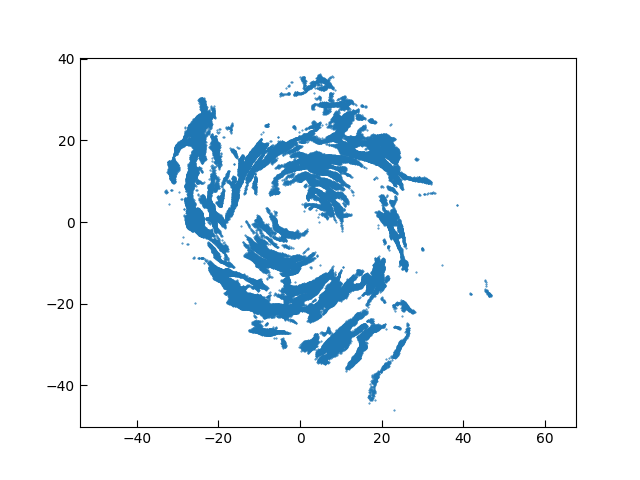

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


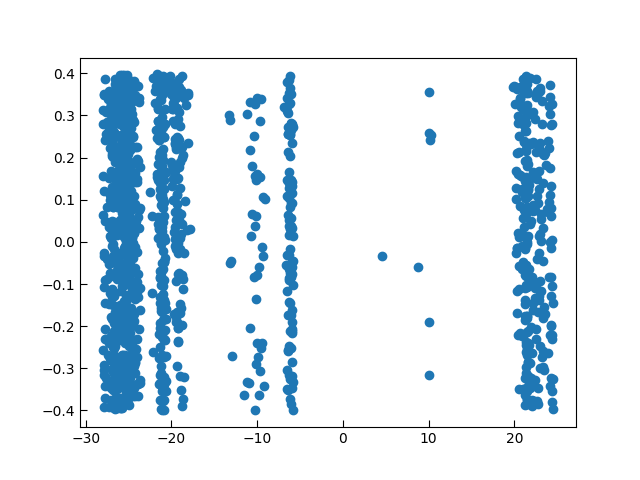

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


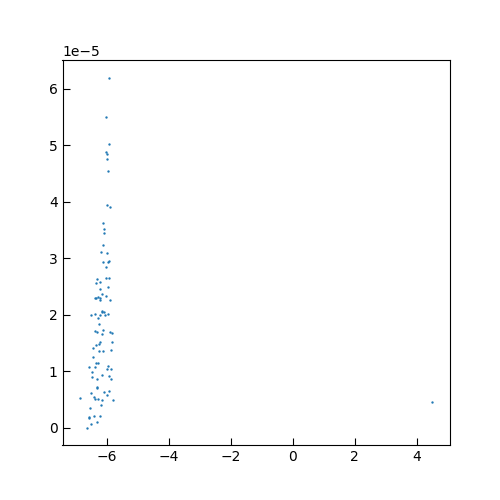

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

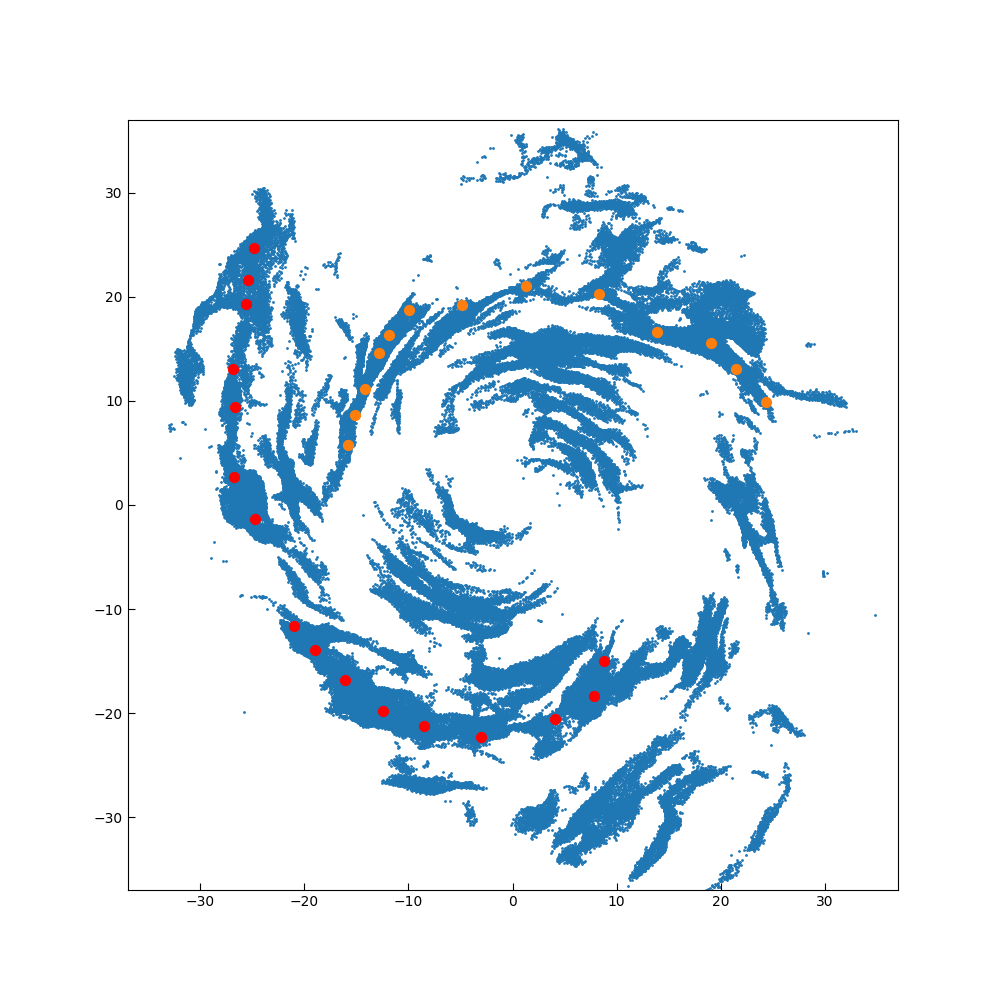

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 37
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [15]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [16]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [17]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [18]:
b = 0.3

In [19]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

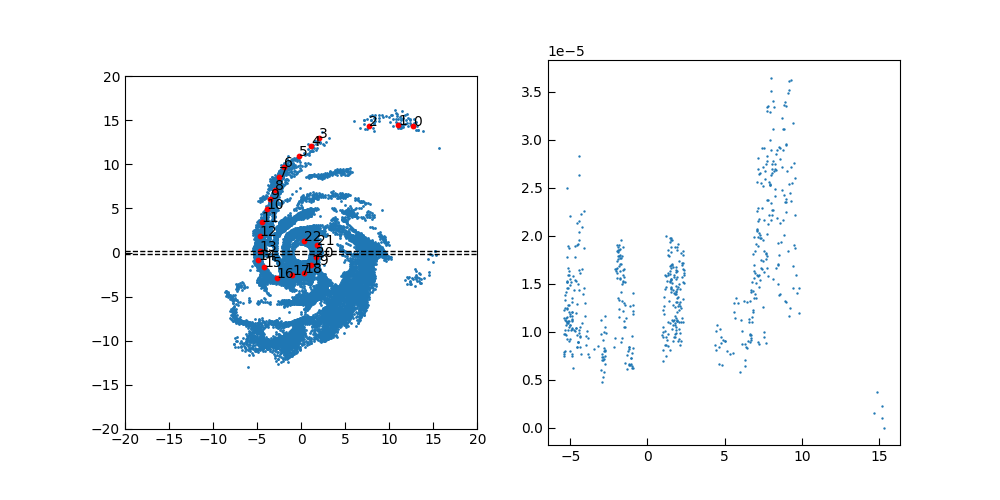

In [20]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

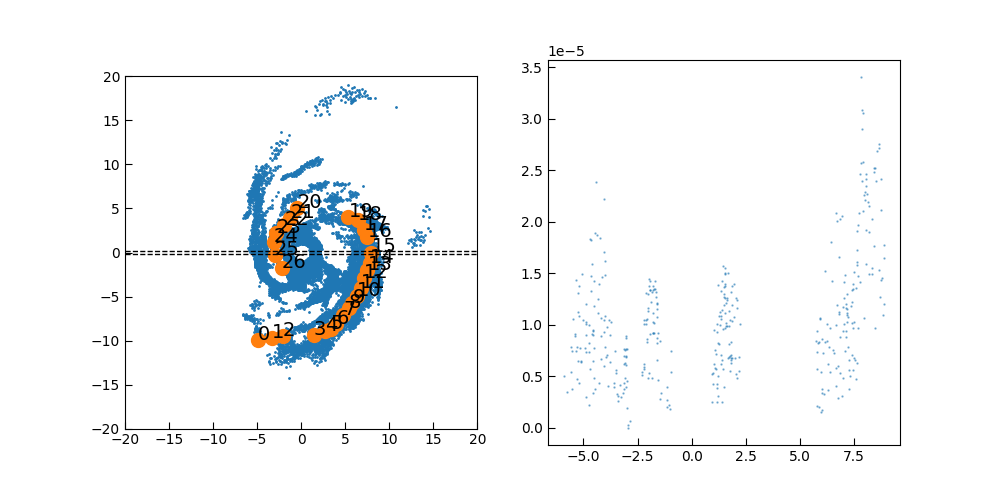

In [21]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 15
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [22]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [23]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [24]:
arm = df_arm2.copy(deep=True)

In [25]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-7.915584,-7.670455,2,0,"({'x_rot': [0.9298452455868048, 0.997775879034...","{'x_rot': [0.9298452455868048, 0.9977758790343...",3.911265,"{'x_rot': [11.02235680669643, 10.1935394780574...","{'x_rot': 11.02235680669643, 'y_rot': -8.88178...","{'x_band': [0.9977758790343665, 1.012152199901..."
1,-6.409091,-8.034091,2,1,"({'x_rot': [0.9646997401459014, 1.014046605595...","{'x_rot': [0.9646997401459014, 1.0140466055955...",4.039029,"{'x_rot': [10.932515353300687, 10.277308160045...","{'x_rot': 10.277308160045067, 'y_rot': 3.55271...","{'x_band': [0.9646997401459014, 1.014046605595..."
2,-5.110390,-8.189935,2,2,"({'x_rot': [0.9826837995777098, 1.014531307473...","{'x_rot': [0.9826837995777098, 1.0145313074731...",4.154521,"{'x_rot': [10.697846359936179, 10.208844048852...","{'x_rot': 9.653554699582477, 'y_rot': -3.55271...","{'x_band': [0.9826837995777098, 1.014531307473..."
3,-1.785714,-9.280844,2,3,"({'x_rot': [0.9526559161601696, 0.927111292248...","{'x_rot': [0.9526559161601696, 0.9271112922488...",4.522303,"{'x_rot': [9.027888724155922, 9.10033395903424...","{'x_rot': 9.451076327872435, 'y_rot': 1.554312...","{'x_band': [0.9526559161601696, 1.059850735746..."
4,-0.487013,-9.332792,2,4,"({'x_rot': [0.907755708792362, 0.8611568615333...","{'x_rot': [0.907755708792362, 0.86115686153335...",4.660253,"{'x_rot': [8.072529858075539, 8.35716561136025...","{'x_rot': 9.345490465638829, 'y_rot': -8.32667...","{'x_band': [1.05606636909612, 0.96515248308227..."
5,0.240260,-9.280844,2,5,"({'x_rot': [0.8746585834859029, 0.816519425822...","{'x_rot': [0.8746585834859029, 0.8165194258227...",4.738271,"{'x_rot': [7.463037899243215, 7.86553906970460...","{'x_rot': 9.283953521418358, 'y_rot': 2.498001...","{'x_band': [1.045022890950064, 0.9593641422102..."
6,1.019481,-8.969156,2,6,"({'x_rot': [0.8313271974050929, 0.760697589909...","{'x_rot': [0.8313271974050929, 0.7606975899091...",4.825568,"{'x_rot': [6.727409571284885, 7.25885966954965...","{'x_rot': 9.026909608850373, 'y_rot': 2.220446...","{'x_band': [1.0251335684613527, 0.945971195638..."
7,2.110390,-8.293831,2,7,"({'x_rot': [0.7513538913213068, 0.662373044509...","{'x_rot': [0.7513538913213068, 0.6623730445095...",4.961554,"{'x_rot': [5.481636165604453, 6.20553679627911...","{'x_rot': 8.55811776997231, 'y_rot': -1.332267...","{'x_band': [1.0200419341216864, 1.115375100533..."
8,2.993506,-7.774351,2,8,"({'x_rot': [0.6703765718490534, 0.566746090007...","{'x_rot': [0.6703765718490534, 0.5667460900073...",5.079941,"{'x_rot': [4.313824641188823, 5.19450446047044...","{'x_rot': 8.330762818957483, 'y_rot': 3.108624...","{'x_band': [0.9921144292344245, 1.092254577546..."
9,3.564935,-7.306818,2,9,"({'x_rot': [0.6053140420666216, 0.491900953410...","{'x_rot': [0.6053140420666216, 0.4919009534107...",5.166303,"{'x_rot': [3.4228494742340727, 4.4102403756329...","{'x_rot': 8.13008941890262, 'y_rot': 5.7731597...","{'x_band': [1.0179723551212365, 0.971344247192..."


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Función para procesar antes del clicker y devolver el clicker
def process_before_clicker(arm, n, clicker):
    print(f"Processing point {n} before clicker...")
    
    fig, (ax, ax2) = plt.subplots(figsize=(7, 7), ncols=2)
    
    x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
    y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
    ax.axvline(x=x_tracing, lw=1, ls='--', color='red')
    
    x_band = arm.iloc[n].rotated_arm_profile['x_band']
    y_band = arm.iloc[n].rotated_arm_profile['y_band']
    ax.scatter(x_band, y_band, s=3, alpha=1)
    ax.set_xlim(x_tracing-2, x_tracing+2)
    
    # Clicker setup
    klicker = clicker(ax, ["limits"], markers=["o"], colors=['red'], markersize=2)
    
    x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
    y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
    x_coords = arm.iloc[n].rotation_coords['x_rot']
    y_coords = arm.iloc[n].rotation_coords['y_rot']
    
    ax2.scatter(x_coords, y_coords, s=3)
    ax2.scatter(x_tracing_all, y_tracing_all, s=100)
    for x, y, id in zip(x_tracing_all, y_tracing_all, arm.id):
        ax2.text(x, y, str(int(id)), fontsize=14)
    
    ax2.axvline(x=x_tracing, lw=1, ls='--', color='red')
    ax2.axhline(y=2, ls='--', lw=1, color='black')
    ax2.axhline(y=-2, ls='--', lw=1, color='black')
    
    ax2.set_xlim(x_tracing-3, x_tracing+3)
    ax2.set_ylim(-2.5, 2.5)
    
    # Muestra la gráfica para permitir interacción con el clicker
    plt.show()
    
    return klicker


(-4.0, 4.0)

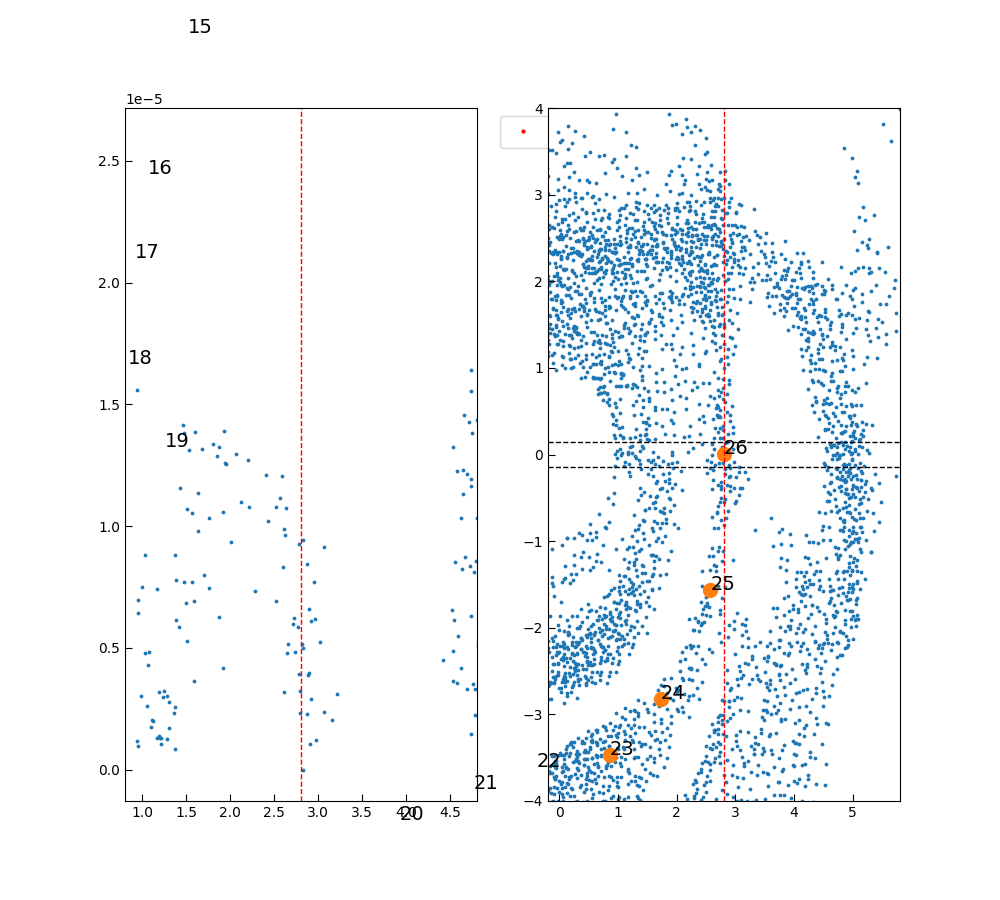

In [685]:
%matplotlib widget

n= 26  #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-4,4)

## %run Routines_and_data/gauss_asym.py

In [669]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [670]:
dict_lims

{'limits': array([[1.94249304e+00, 5.91775440e-07],
        [2.05604143e+00, 2.52242677e-06],
        [2.20365433e+00, 4.78169960e-06],
        [2.30584788e+00, 6.30157405e-06],
        [2.37397691e+00, 7.36959393e-06],
        [2.44210595e+00, 9.17701219e-06],
        [2.51023498e+00, 1.06147313e-05],
        [2.57836401e+00, 1.09844305e-05],
        [2.65784788e+00, 1.13541296e-05],
        [2.86223498e+00, 1.12308966e-05],
        [3.02120272e+00, 1.02450321e-05],
        [3.20288014e+00, 9.38240063e-06],
        [3.28236401e+00, 7.82144849e-06],
        [3.36184788e+00, 6.54804017e-06],
        [3.41862208e+00, 5.35678723e-06],
        [3.41862208e+00, 4.65846653e-06],
        [3.46404143e+00, 4.12445659e-06],
        [3.56623498e+00, 2.89212596e-06],
        [3.65707369e+00, 1.41332920e-06]])}

In [671]:
def get_asym_gaussian_fit_daniel(dict_lims, df_arm, n, bin_size):
    # Limits  
    limits = dict_lims['limits']
    limits_x = limits[:, 0]
    limits_y = limits[:, 1]
    
    # Interpolación de los límites
    f = interpolate.interp1d(limits_x, limits_y, kind='linear')

    # Datos de banda rotada
    x_band = df_arm.iloc[n].rotated_arm_profile['x_band']
    y_band = df_arm.iloc[n].rotated_arm_profile['y_band']

    # Filtrar puntos dentro de los límites definidos
    x_band_lim = x_band[(x_band >= np.min(limits_x)) & (x_band <= np.max(limits_x))]
    y_band_lim = y_band[(x_band >= np.min(limits_x)) & (x_band <= np.max(limits_x))]

    # Ajuste de los puntos que estén por debajo de la curva límite interpolada
    x_band_final = []
    y_band_final = []

    for x, y in zip(x_band_lim, y_band_lim):
        interpolated_value = f(x)
        if y <= interpolated_value:  # Cambiar "<" a "<=" para incluir los puntos en la curva
            x_band_final.append(x)
            y_band_final.append(y)

    # Convertir a numpy arrays
    x_band_final = np.array(x_band_final)
    y_band_final = np.array(y_band_final)

    # Verifica si tenemos suficientes puntos para ajustar
    if len(x_band_final) < 3:
        raise ValueError(f"No hay suficientes puntos para el ajuste en la región definida para n={n}")

    # Realizar el ajuste asimétrico gaussiano
    arm_fit = asym_gauss(x_band_final, y_band_final, np.min(x_band_final), np.max(x_band_final), bin_size)

    return {
        'arm_fit': arm_fit['model_fit'],
        'x_max': arm_fit['x_max'],
        'y_max': arm_fit['y_max']
    }


In [672]:
delta = 0.005
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [673]:
n

26

(1.736685281987815e-15, 1.2901007327927728e-05)

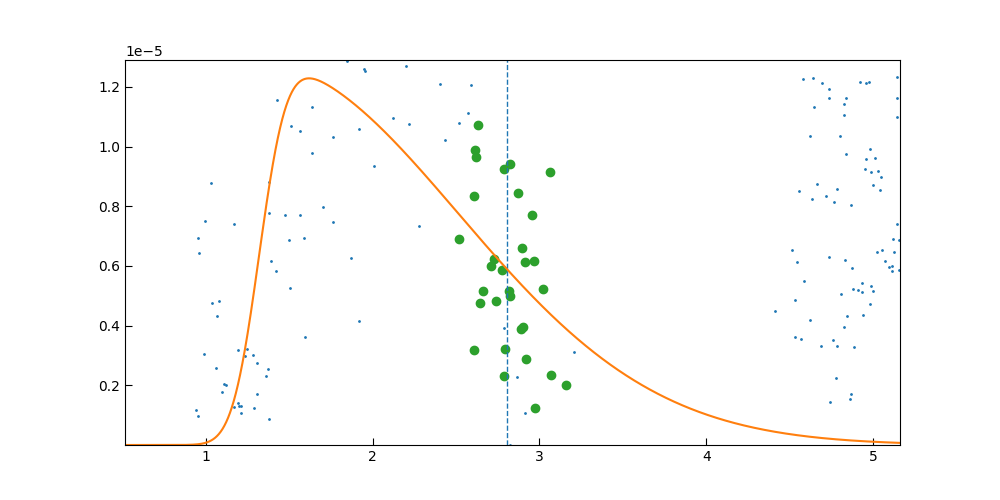

In [687]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [688]:
fractured = False

In [689]:
#df_params.tail()

In [690]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000019,10.928621,0.050,False,-5.173784,0.0,0.514145,1.623699e-06,0.030123,3.072385,0.072146,"[10.019373813688695, 10.173604508850502, 10.24...",-7.915584,"[6.737830844461603e-06, 9.252392339954327e-06,...",-7.670455
1,0.000018,10.416765,0.005,False,-22.021685,1.0,0.430623,2.655317e-06,0.016828,57.601851,0.084430,"[9.897501137133187, 9.911999403985519, 9.92957...",-6.409091,"[2.5684156167959586e-05, 1.1662606374806103e-0...",-8.034091
2,0.000020,9.946984,0.005,False,-1.296957,2.0,0.385465,4.437487e-06,0.461543,5.383193,0.501131,"[9.379070233749419, 9.404302066906055, 9.48736...",-5.110390,"[1.782181504233689e-05, 1.706145101964122e-05,...",-8.189935
3,0.000036,9.227891,0.005,False,6.830550,3.0,1.087833,4.245127e-05,0.107568,17.871477,1.616349,"[9.22066861989842, 9.34291864557413, 9.3567135...",-1.785714,"[1.3504350999783527e-05, 1.5736220162372992e-0...",-9.280844
4,0.000081,9.363326,0.005,False,-0.008388,4.0,1.177066,1.617145e-05,53598.733015,57075.673213,356.600550,"[8.325730147076221, 8.335618385938364, 8.40831...",-0.487013,"[1.4400493464651327e-05, 1.5643648904949294e-0...",-9.332792
5,0.000050,8.289447,0.005,False,2.660716,5.0,1.293499,9.289974e-06,0.196291,3.543536,0.468520,"[8.21502525921419, 8.350363071204885, 8.449006...",0.240260,"[1.577637604271569e-05, 1.2696672652243432e-05...",-9.280844
6,0.000024,8.252799,0.005,False,1.578283,6.0,0.759293,6.032263e-06,0.512143,3.931555,0.569033,"[7.6420206498987575, 8.193892307836931, 8.8404...",1.019481,"[4.354153660288487e-06, 9.724961579999093e-06,...",-8.969156
7,0.000053,7.755243,0.005,False,3.807693,7.0,1.293401,3.270076e-06,0.061474,1.388913,0.144798,"[7.278780859643688, 7.352453068623445, 7.37889...",2.110390,"[3.741778185339923e-06, 7.989647095454619e-06,...",-8.293831
8,0.000061,8.246852,0.005,False,-0.016874,9.0,1.134254,4.657888e-06,27962.033616,30900.358407,142.447383,"[6.565069478964507, 6.678414327420043, 6.70134...",3.564935,"[3.293388867360991e-06, 9.994203232491248e-06,...",-7.306818
9,0.000049,9.310127,0.005,False,-2.082305,10.0,1.285893,3.499665e-06,0.154325,1.312250,0.255447,"[7.094227411760636, 7.207253516790237, 7.21870...",4.344156,"[3.0461724177691092e-06, 1.1145177303392345e-0...",-6.787338


In [691]:
## añadir n 

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [692]:
df_params['y']

0     [6.737830844461603e-06, 9.252392339954327e-06,...
1     [2.5684156167959586e-05, 1.1662606374806103e-0...
2     [1.782181504233689e-05, 1.706145101964122e-05,...
3     [1.3504350999783527e-05, 1.5736220162372992e-0...
4     [1.4400493464651327e-05, 1.5643648904949294e-0...
5     [1.577637604271569e-05, 1.2696672652243432e-05...
6     [4.354153660288487e-06, 9.724961579999093e-06,...
7     [3.741778185339923e-06, 7.989647095454619e-06,...
8     [3.293388867360991e-06, 9.994203232491248e-06,...
9     [3.0461724177691092e-06, 1.1145177303392345e-0...
10    [5.238291914060332e-06, 6.477527371910462e-06,...
11    [7.399327464779212e-06, 3.7429942552732075e-06...
12    [3.061733127876393e-06, 6.722013786237034e-06,...
13    [3.051174875484731e-06, 5.518760935204826e-06,...
14    [3.6049688615926484e-06, 5.4373536117132096e-0...
15    [4.271122536339418e-06, 5.171706950111896e-06,...
16    [4.795351993833142e-06, 9.074612270396534e-06,...
17    [3.947751878203178e-06, 4.7894649541806876

In [693]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 1.91249e-05
center                                                        1.32048
delta                                                           0.005
fractured                                                       False
gamma                                                         9.29264
id_tracing                                                         26
sigma                                                          1.1916
stderr_amplitude                                                 None
stderr_center                                                    None
stderr_gamma                                                     None
stderr_sigma                                                     None
x                   [2.5153224110610624, 2.605118640825137, 2.6075...
x_tracing                                                    -2.66883
y                   [6.9176489673279e-06, 8.338200600268205e-06, 3...
y_tracing           

In [150]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [694]:
arm.iloc[n].id

26

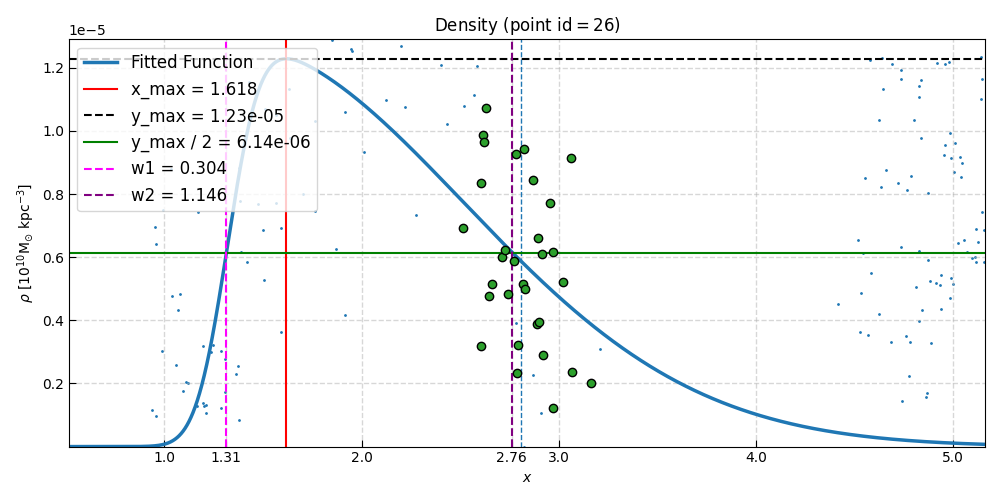

In [695]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

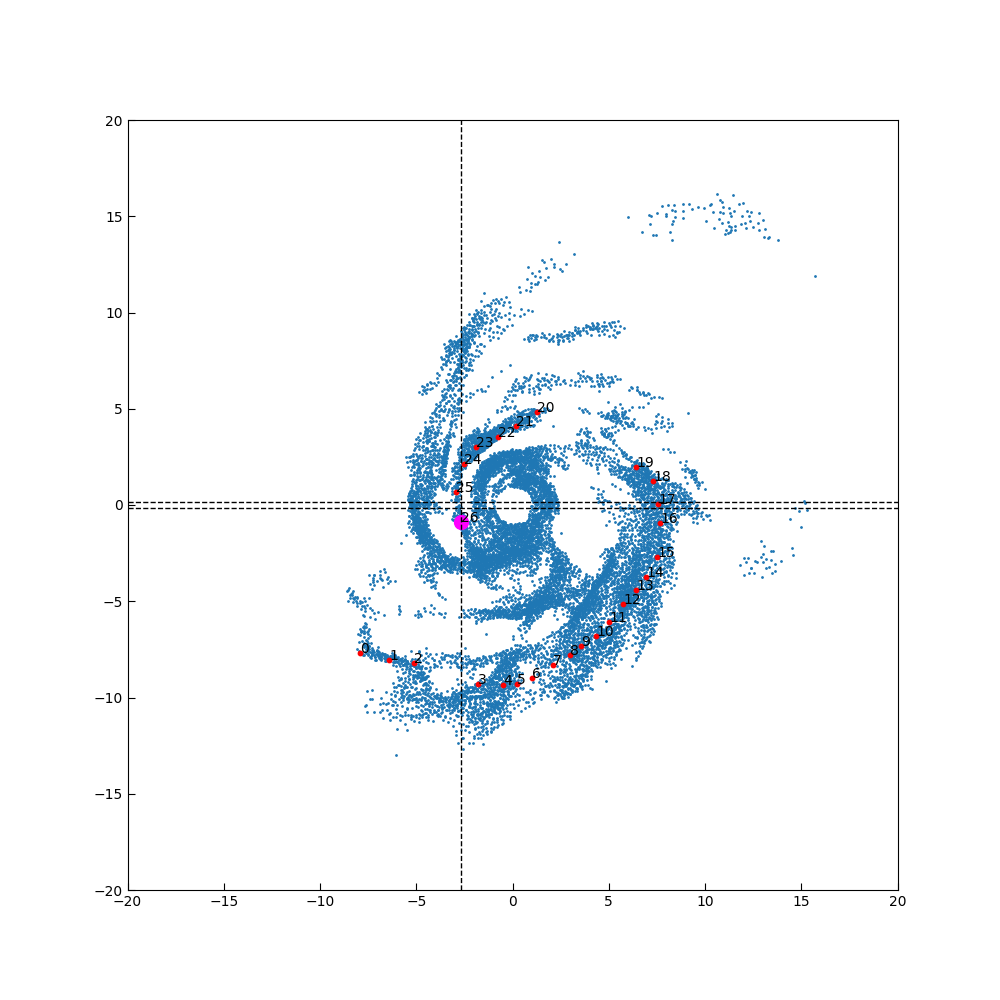

In [696]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [697]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

In [698]:
df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_.csv')

## arm 1

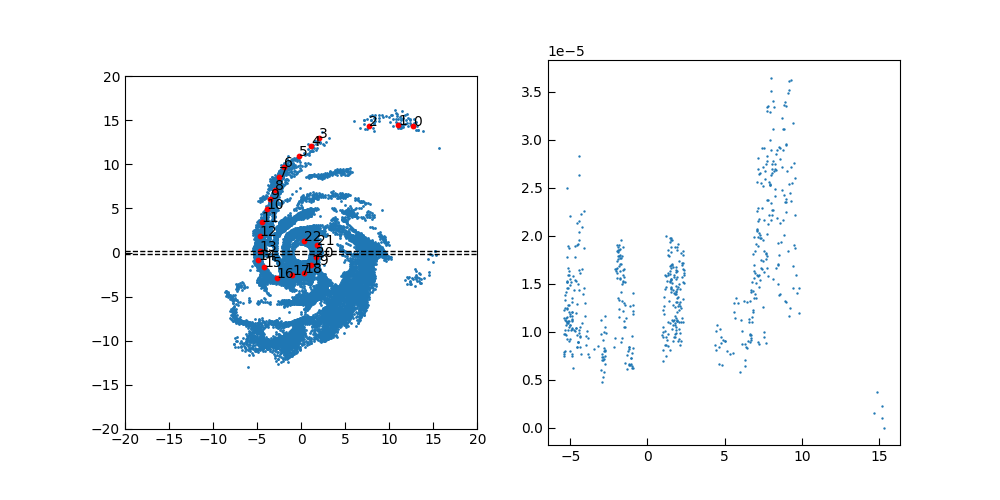

In [699]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [700]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [701]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,12.707792,14.355519,1,0,"({'x_rot': [-0.952586684772841, -1.00949898468...","{'x_rot': [-0.952586684772841, -1.009498984680...",0.846207,"{'x_rot': [19.17208706301948, 18.1136053217362...","{'x_rot': 19.17208706301948, 'y_rot': -1.77635...","{'x_band': [-0.952586684772841, -1.00949898468..."
1,10.993506,14.459416,1,1,"({'x_rot': [-0.9693728619868038, -1.0152350559...","{'x_rot': [-0.9693728619868038, -1.01523505591...",0.920735,"{'x_rot': [19.118866893315158, 18.164027198438...","{'x_rot': 18.164027198438397, 'y_rot': 1.77635...","{'x_band': [-0.9693728619868038, -1.0152350559..."
2,7.668831,14.407468,1,2,"({'x_rot': [-0.987180225629339, -1.00839702645...","{'x_rot': [-0.987180225629339, -1.008397026454...",1.081658,"{'x_rot': [18.643115133616003, 17.929344756523...","{'x_rot': 16.32133855402622, 'y_rot': 0.0}","{'x_band': [-0.987180225629339, -1.00839702645..."
3,2.006494,12.952922,1,3,"({'x_rot': [-0.9425372413147356, -0.9113733635...","{'x_rot': [-0.9425372413147356, -0.91137336352...",1.417111,"{'x_rot': [16.13164018168546, 15.9718874191430...","{'x_rot': 13.107410367739387, 'y_rot': -1.1102...","{'x_band': [-0.9425372413147356, -1.0608117701..."
4,1.175325,12.069805,1,4,"({'x_rot': [-0.9243236923972048, -0.8845049183...","{'x_rot': [-0.9243236923972048, -0.88450491835...",1.473725,"{'x_rot': [15.519562370116002, 15.456822768777...","{'x_rot': 12.126895131606178, 'y_rot': 1.11022...","{'x_band': [-1.0595138540081392, -0.9658222925..."
5,-0.279221,10.926948,1,5,"({'x_rot': [-0.874811805124579, -0.81672135862...","{'x_rot': [-0.874811805124579, -0.816721358627...",1.596344,"{'x_rot': [14.026213412902207, 14.173867162457...","{'x_rot': 10.930514991230744, 'y_rot': 1.27675...","{'x_band': [-1.0450837944151616, -0.9594014081..."
6,-1.941558,9.680195,1,6,"({'x_rot': [-0.7831913011060156, -0.7009475595...","{'x_rot': [-0.7831913011060156, -0.70094755955...",1.768740,"{'x_rot': [11.576165769162134, 12.015153643184...","{'x_rot': 9.872984384091133, 'y_rot': 2.220446...","{'x_band': [-0.9260715773668076, -1.1137356536..."
7,-2.512987,8.537338,1,7,"({'x_rot': [-0.7270565770638069, -0.6333404699...","{'x_rot': [-0.7270565770638069, -0.63334046991...",1.857064,"{'x_rot': [10.182967749098019, 10.766704963184...","{'x_rot': 8.899507744151386, 'y_rot': 4.440892...","{'x_band': [-1.0128112868177148, -1.1097981022..."
8,-2.928571,7.082792,1,8,"({'x_rot': [-0.6523925896673177, -0.5459029858...","{'x_rot': [-0.6523925896673177, -0.54590298581...",1.962867,"{'x_rot': [8.410545745949815, 9.16159079699172...","{'x_rot': 7.664364035652725, 'y_rot': 4.440892...","{'x_band': [-1.0855402207062137, -0.9764650801..."
9,-3.551948,6.095779,1,9,"({'x_rot': [-0.5462195589267671, -0.4251260581...","{'x_rot': [-0.5462195589267671, -0.42512605816...",2.098390,"{'x_rot': [6.005652566973281, 6.95848852004662...","{'x_rot': 7.0551299968336, 'y_rot': 2.66453525...","{'x_band': [-1.0011710803621217, -0.9681928246..."


(-2.5, 2.5)

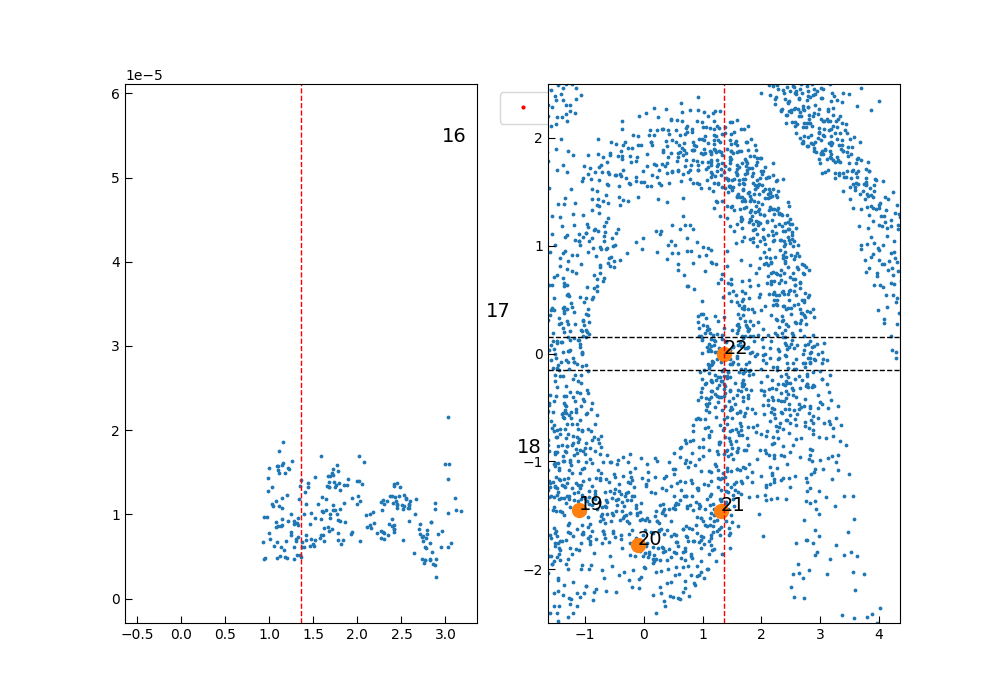

In [893]:
n= 22 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [894]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [895]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(6.138309722493438e-10, 1.529471105751015e-05)

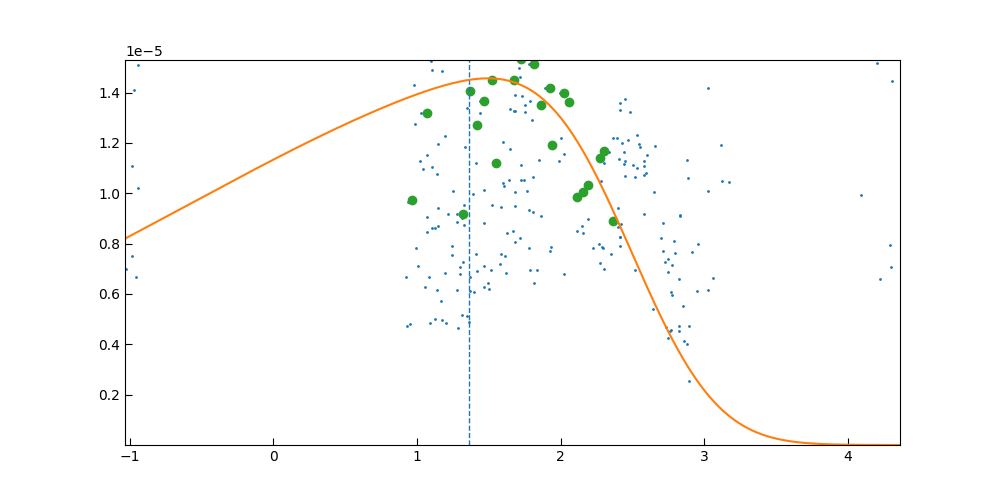

In [896]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [897]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [898]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                   6.059e-05
center                                                        2.48148
delta                                                            0.05
fractured                                                       False
gamma                                                          -6.417
id_tracing                                                         22
sigma                                                          3.0901
stderr_amplitude                                          7.09918e-05
stderr_center                                                0.148394
stderr_gamma                                                   14.439
stderr_sigma                                                  4.42055
x                   [0.9686808687164816, 1.024813049327737, 1.0732...
x_tracing                                                    0.344156
y                   [9.731688316365899e-06, 1.5489898595279217e-05...
y_tracing           

In [899]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000010,11.333019,0.05,False,4.388173,4.0,0.328757,1.548219e-05,0.529017,99.286131,0.177480,"[11.361275914258554, 11.553143422007672, 11.58...",1.175325,"[1.4859616391502826e-05, 1.884916737007508e-05...",12.069805
1,0.000030,10.101443,0.05,False,0.005897,5.0,0.875466,2.326965e-05,66587.206557,95338.244594,577.683092,"[9.324536419915178, 9.641965433108469, 9.85491...",-0.279221,"[1.0231049351422233e-05, 9.334876642362357e-06...",10.926948
2,0.000041,10.145472,0.05,False,-2.882740,6.0,0.721861,4.354278e-06,0.075197,2.342419,0.154371,"[8.98655083666396, 9.02196828417386, 9.1086688...",-1.941558,"[1.1978288746028094e-05, 1.4849309006968454e-0...",9.680195
3,0.000061,9.469835,0.05,False,-3.544609,7.0,1.092547,4.315215e-06,0.064458,1.892053,0.121028,"[7.380573832602369, 7.391948078906636, 7.50989...",-2.512987,"[7.413491257113073e-06, 4.772603608785055e-06,...",8.537338
4,0.000042,8.897626,0.05,False,-1.442455,8.0,1.222159,3.769508e-06,0.275116,1.527003,0.297820,"[6.2342765388339565, 6.343569105705918, 6.5581...",-2.928571,"[1.4896658208859495e-06, 2.288096790938734e-06...",7.082792
5,0.000012,7.161313,0.05,False,-1.378572,9.0,0.733505,1.702806e-06,0.401237,2.836810,0.412835,"[5.811482649053394, 5.950762393108479, 5.98004...",-3.551948,"[1.5035849087466496e-06, 5.383259736567648e-06...",6.095779
6,0.000017,5.751908,0.05,False,-1.408064,11.0,0.789391,1.171788e-06,0.248147,1.680510,0.272547,"[4.387636365320973, 4.423700766258118, 4.56494...",-4.487013,"[4.751862385636092e-06, 4.162763534341211e-06,...",3.498377
7,0.000028,3.904896,0.05,False,2.109368,12.0,1.374660,2.810552e-06,0.223733,1.690000,0.417841,"[3.411697660500293, 3.4613944236914955, 3.5006...",-4.694805,"[3.0294844900186904e-06, 3.3907474024426173e-0...",1.887987
8,0.000068,4.661880,0.05,False,-0.009297,13.0,1.366693,4.267634e-05,86047.502788,78931.129167,1122.749553,"[3.9749622175495927, 4.091038517204139, 4.1390...",-4.694805,"[1.1320346424223475e-05, 2.0416629854968494e-0...",0.225649
9,0.000011,4.879365,0.05,False,0.686374,14.0,0.393644,1.363729e-06,0.889328,4.443072,0.495810,"[4.298750736065823, 4.480197704769558, 4.59564...",-4.902597,"[2.877623224295711e-06, 4.410360268359912e-06,...",-0.813312


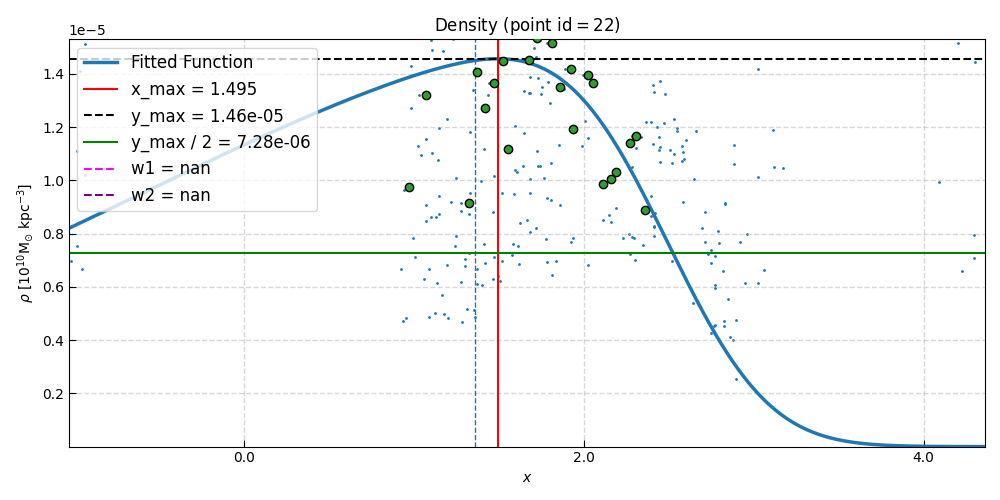

In [900]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

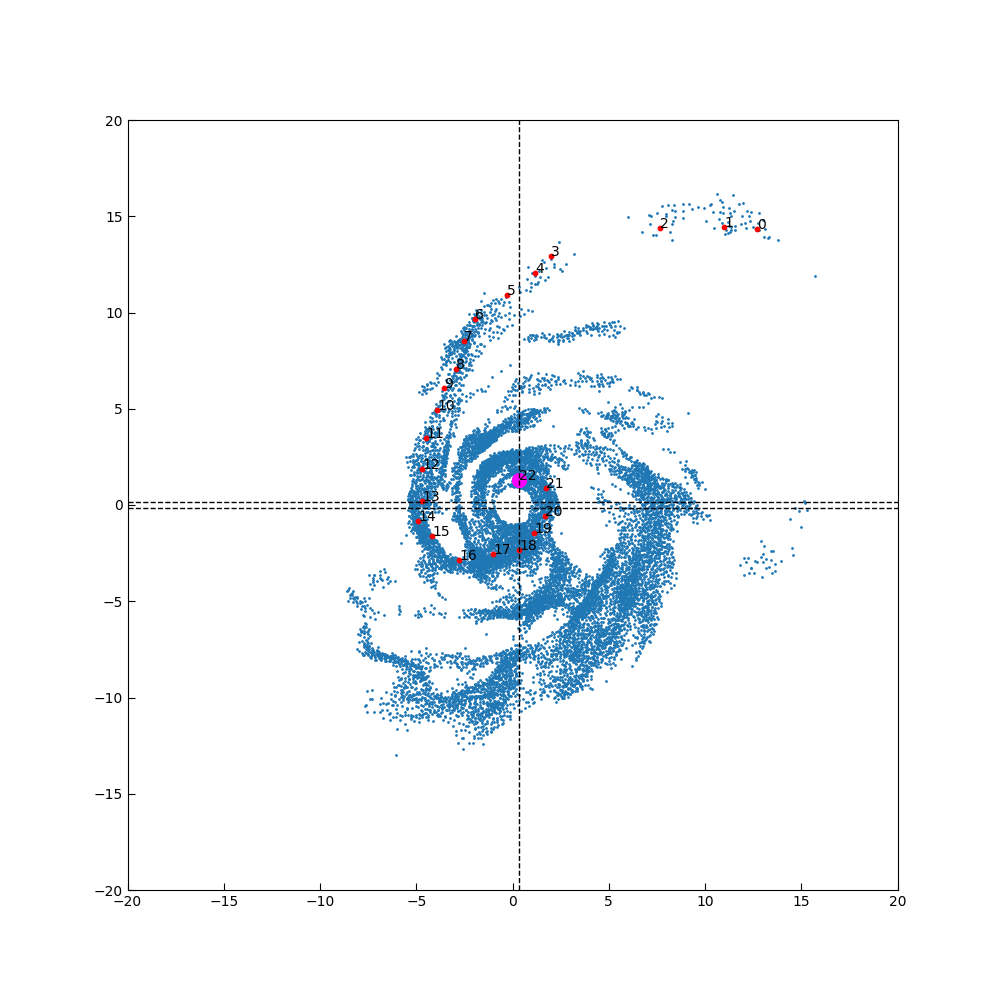

In [901]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [902]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')

In [903]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}__.csv', index = False)
